# Exploration of geographical biases in NER algorithms

This notebook is made to explore possible geographical biases in NER algorithms. 

Just like the exploration made on first names, we are testing the four NER models available in Spacy 3.1.

Those models will be tested on two different things:
- country names
- city names

The same kind of procedure is used here. 

The main difference comes from the fact there does not exist a kind of winogender schema for geographical named entity. 
Therefore, we need to construct the sentences ourselves, by:

- Selecting a good number of city/country names from different parts of the world. 
- Getting the wikipedia summary of those cities/countries
- Selecting the sentences containing the city/country names. 
- Replacing the city and country names respectively by `$CITY` and `$COUNTRY`.

This procedure allows us to apply the model on real sentences. 

The rest of the notebook is basically the same as the notebook of the exploration of the first names.

First, we will define some utility functions we will then be using for the countries and the cities. 

## Importing the packages

In [2]:
import geopandas as gpd
import wikipedia
import pandas as pd

import re
from tqdm import tqdm
import spacy 

import matplotlib.pyplot as plt

## Utils

In [3]:
nlp_sm = spacy.load("en_core_web_sm")
nlp_md = spacy.load("en_core_web_md")
nlp_lg = spacy.load("en_core_web_lg")
nlp_trf = spacy.load("en_core_web_trf")

C:\Users\adrie\Anaconda3\lib\site-packages\spacy\util.py:833: UserWarning: [W095] Model 'en_core_web_sm' (3.1.0) was trained with spaCy v3.1 and may not be 100% compatible with the current version (3.2.0). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
C:\Users\adrie\Anaconda3\lib\site-packages\spacy\util.py:833: UserWarning: [W095] Model 'en_core_web_md' (3.1.0) was trained with spaCy v3.1 and may not be 100% compatible with the current version (3.2.0). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
C:\Users\adrie\Anaconda3\lib\site-packages\spacy\util.py:833: UserWarning: [W095] Model 'en_core_web_lg' (3.1.0) was tra

In [4]:
def predict_NER_spacy(text, model):
    """
    model: str 
        either:
            'sm'
            'md'
            'lg'
            'trf'
    """
    if model=='sm':
        doc=nlp_sm(text)
    elif model=='md':
        doc=nlp_md(text)
    elif model=='lg':
        doc=nlp_lg(text)
    elif model=='trf':
        doc=nlp_trf(text)
    else:
        return np.nan
        
    predicted_label_liste=[str(ent).strip() for ent in doc.ents]
    return predicted_label_liste

#Is the name found ?? 
def check_names_prediction_country(row):
    var_0=0
    if row['name'] in row['spacy_prediction']:
        var_0 = 1
    return var_0

In [5]:
def compute_stats_names(df_test_company, model):
    """
    Model is a str of the name of the model
    
    """
    #Creating a new dataframe:
    df_temp=pd.DataFrame()
    df_temp['score_'+model] = pd.concat([df_test_company['found']])
    df_temp['name'] = pd.concat([df_test_company['name']])
    #We then have one 'mean' score per name:
    df_temp = df_temp.groupby('name').agg({'score_'+model:'mean'}).reset_index(drop=False)
    return df_temp

In [6]:
def main_geo(df_test_country):

    #We define the df of the results:
    df_results=pd.DataFrame(data={'name':df_test_country['name'].unique()})
    #Then, we apply the models:
    for model in ['sm', 'md', 'lg', 'trf']:
        
        print('Testing the model: '+model)
        
        tqdm.pandas()
        df_test_country['spacy_prediction'] = df_test_country['sentence'].progress_apply(lambda x: predict_NER_spacy(x, model))
        #We replace the list with a string, because otherwise for a list like : [Emily if Camila], neither Emily or Camila 
        #Would be mark as 1 by the test above. 
        df_test_country['spacy_prediction'] = df_test_country['spacy_prediction'].apply(lambda l : ' '.join(l))
        #We apply the function to check if the names were understood as NER by the model: 
        df_test_country['found'] = df_test_country.apply(check_names_prediction_country, axis=1)
        
        
        #computing the stats:
        #And merging with the results df:
        df_results = df_results.merge(compute_stats_names(df_test_country, model), left_on='name', right_on='name', how='right')
    return df_results

## Countries

We are using the world dataframe available inside geopandas

In [7]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [8]:
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [9]:
print('There are {} countries in the world dataset of Geopandas'.format(world.shape[0]))

There are 177 countries in the world dataset of Geopandas


### Sentence templates

We are using the wikipedia API to retrieve the sentences inside the summary of the wikipedia pages of the country containing the name of this country. 

Then, for each sentence we replace the name of the country by '$COUNTRY', in order to use those sentences as templates in an other part. 

In [60]:
list_sentences=[]
list_countries=[]
for country in world['name'].unique():
    try:
        #We are adding country to avoid any mistakes and to find more countries.
        summary = wikipedia.summary(country + ' country')
        for sentence in summary.split('. '):
            if country.lower() in sentence.lower():
                list_sentences.append(sentence)
                list_countries.append(country)
    except:
        print('not found : ', country)
        
#Constructing the dataframe:
df_sentences_template_country = pd.DataFrame(data = {'sentences':list_sentences, 'name':list_countries})

not found :  W. Sahara
not found :  United States of America
not found :  Kazakhstan
not found :  Uzbekistan
not found :  Papua New Guinea
not found :  Dem. Rep. Congo
not found :  Dominican Rep.
not found :  Falkland Is.
not found :  Timor-Leste
not found :  Côte d'Ivoire
not found :  Guinea-Bissau
not found :  Central African Rep.


C:\Users\adrie\Anaconda3\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file C:\Users\adrie\Anaconda3\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


not found :  Congo
not found :  Eq. Guinea
not found :  Czechia
not found :  Bosnia and Herz.


Almost all of the countries were found, before cleaning the sentences, let's have a look at them:

In [61]:
df_sentences_template_country.head()

,sentences,name
0,"Fiji ( (listen) FEE-jee; Fijian: Viti, [ˈβitʃi...",Fiji
1,Fiji consists of an archipelago of more than 3...,Fiji
2,About three-quarters of Fijians live on Viti L...,Fiji
3,The interior of Viti Levu is sparsely inhabite...,Fiji
4,The geothermal systems on Viti Levu are non-vo...,Fiji


In [64]:
df_sentences_template_country.loc[0]['sentences']

'Fiji ( (listen) FEE-jee; Fijian: Viti, [ˈβitʃi]; Fiji Hindi: फ़िजी, Fijī), officially the Republic of Fiji, is an island country in Melanesia, part of Oceania in the South Pacific Ocean'

1623 sentences were found, and some seem quite odd - especially the first ones. 

For the sake of simplicity, we are only taking the last one.

In [65]:
df_sentences_template_country = df_sentences_template_country.groupby('name').agg({'sentences':'last'}).reset_index()

Now we can clean the sentences:

In [66]:
def clean_template(row):
    """
    function clean_template applied to each row in order to replace the company names in the sentences by '$COMPANY'
    to use them after in the construction of the sentences. 
    """
    #Check for company names in the sentence, ignoring the case:
    sent = row['sentences']
    while re.search(row['name'], sent, re.IGNORECASE):
        match = re.search(row['name'], sent, re.IGNORECASE)
        sent = sent[:match.span()[0]] + '$COUNTRY' + sent[match.span()[1]:]
        return sent

In [67]:
df_sentences_template_country['clean_sentence'] = df_sentences_template_country.apply(clean_template, axis=1)

Example of cleaned sentence:

In [69]:
df_sentences_template_country.sample(1)['clean_sentence'].values[0]

'$COUNTRY is a founding member of the United Nations, the OPEC as well as of the Arab League, OIC, Non-Aligned Movement and the IMF.'

We save the template

In [10]:
#df_sentences_template_country.to_csv('data/templates/template_country.csv', index=False)
df_sentences_template_country = pd.read_csv('data/templates/template_country.csv')

### Constructing the sentences

In [11]:
print('We have {} sentences'.format(df_sentences_template_country.shape[0]))
print('And {} country names'.format(world.shape[0]))
print('This gives {} possible sentences.'.format(df_sentences_template_country.shape[0] * world.shape[0]))

We have 159 sentences
And 177 country names
This gives 28143 possible sentences.


Then, we can compute all the sentences - every country names and every sentences. 

In [12]:
list_sentences_modified=[]
list_countries=[]
for country in world['name'].unique():
    for sentence in df_sentences_template_country['clean_sentence'].unique():
        list_sentences_modified.append(sentence.replace('$COUNTRY', country))
        list_countries.append(country)
df_country_test = pd.DataFrame(data={'sentence':list_sentences_modified, 'name':list_countries})

In [13]:
df_country_test.head()

,sentence,name
0,"Fiji's economy is the world's 96th largest, wi...",Fiji
1,"Fiji is a member of the United Nations, World ...",Fiji
2,Fiji's military is one of the largest in Afric...,Fiji
3,Fijin culture reflects centuries of Portuguese...,Fiji
4,Seven sovereign states have made territorial c...,Fiji


### Applying the model

In [22]:
df_results_country = main_geo(df_country_test)

Testing the model: sm


100%|███████████████████████████████████████████████████████████████████████████| 28143/28143 [04:20<00:00, 107.97it/s]


Testing the model: md


100%|████████████████████████████████████████████████████████████████████████████| 28143/28143 [04:52<00:00, 96.23it/s]


Testing the model: lg


100%|████████████████████████████████████████████████████████████████████████████| 28143/28143 [04:48<00:00, 97.50it/s]


Testing the model: trf


100%|████████████████████████████████████████████████████████████████████████████| 28143/28143 [55:56<00:00,  8.38it/s]


Then we save the results:

In [14]:
#df_results_country.to_csv('data/results/geographical/results_country.csv', index=False)
df_results_country = pd.read_csv('data/results/geographical/results_country.csv')

In [15]:
#Computing the average score:
df_results_country['avg_score']=df_results_country[['score_sm', 'score_md', 'score_lg', 'score_trf']].mean(axis=1)

In [16]:
df_results_country_merge = world.merge(df_results_country, left_on='name', right_on='name', how='right')

### Results

#### Map by country

We can plot the map for each model: 

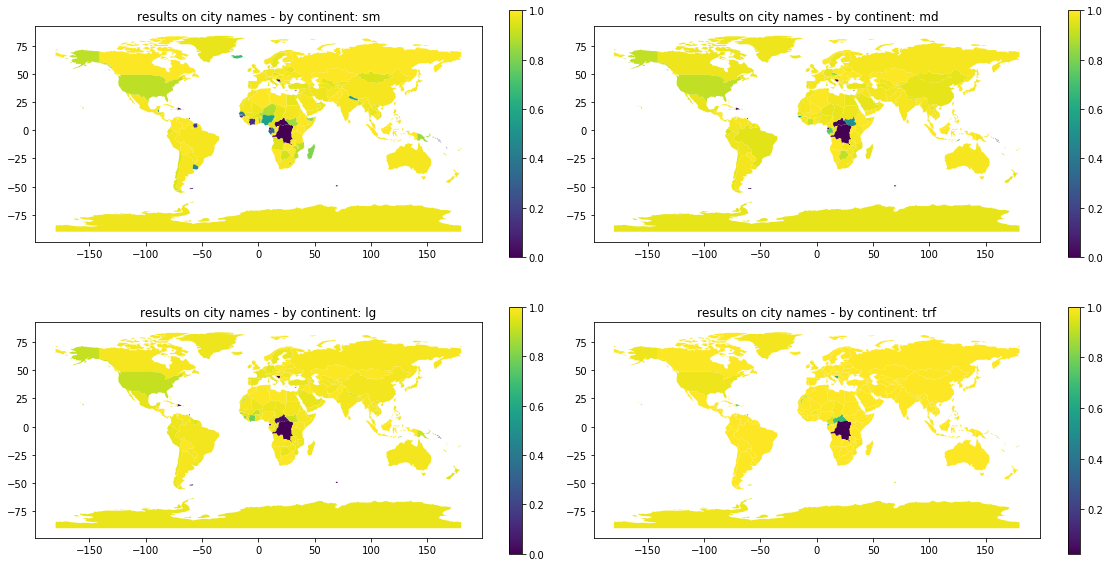

In [17]:
fig, axs = plt.subplots(2,2, figsize=(20, 10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .2, wspace=0.001)

axs = axs.ravel()

for i in range(4):
    model = ['sm','md','lg','trf'][i]
    
    #Defining the figure:
    axs[i].set_title('results on city names - by continent: ' + model)
    df_results_country_merge.plot(column='score_'+model, legend=True, ax = axs[i])
       
plt.savefig('images/results/score_each_models_country_name.png', bbox_inches='tight')
plt.show()

On average:

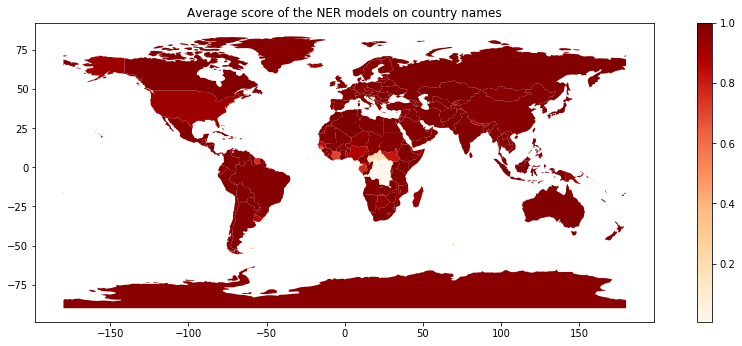

In [18]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15.5, 5.5)
plt.title('Average score of the NER models on country names')
df_results_country_merge.plot('avg_score', ax=ax, legend=True, cmap='OrRd')
#Saving the figure:
plt.savefig('images/results/avg_score_country_names.png', bbox_inches='tight')
plt.show()

#### results by continent

In [19]:
df_results_country_merge.groupby('continent').mean()

,pop_est,gdp_md_est,score_sm,score_md,score_lg,score_trf,avg_score
continent,,,,,,,
Africa,2.390542e+07,1.181430e+05,0.838204,0.896535,0.909113,0.961154,0.901252
Antarctica,4.050000e+03,8.100000e+02,0.974843,0.962264,0.968553,0.974843,0.970126
Asia,9.338606e+07,1.179460e+06,0.935903,0.949150,0.958250,0.992908,0.959053
Europe,1.913842e+07,6.483302e+05,0.937429,0.955652,0.956942,0.986293,0.959079
North America,3.183567e+07,1.305841e+06,0.850454,0.873864,0.872467,0.946191,0.885744
Oceania,5.254692e+06,2.018407e+05,0.743037,0.840970,0.823899,0.976640,0.846137
Seven seas (open ocean),1.400000e+02,1.600000e+01,0.006289,0.000000,0.000000,0.943396,0.237421
South America,3.219544e+07,4.905455e+05,0.811321,0.903241,0.900822,0.991292,0.901669


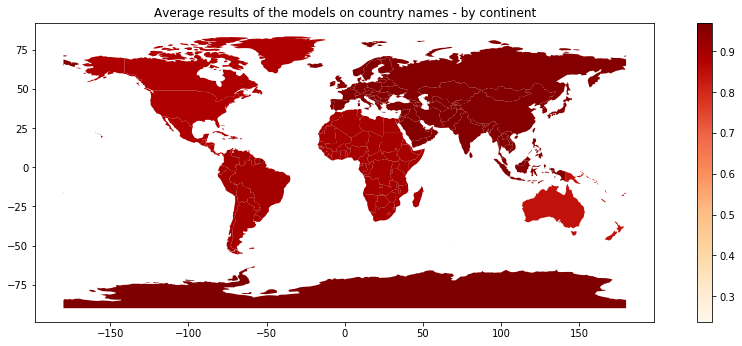

In [20]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15.5, 5.5)
plt.title('Average results of the models on country names - by continent')
world.merge(df_results_country_merge.groupby('continent').mean().reset_index(drop=False), left_on='continent', right_on='continent', how='left').plot('avg_score', ax=ax, legend=True, cmap='OrRd')
#Saving the figure:
plt.savefig('images/results/avg_score_country_names_by_continent.png', bbox_inches='tight')
plt.show()

#### Correlations with GDP and Population:

In [21]:
df_results_country_merge.corr()

,pop_est,gdp_md_est,score_sm,score_md,score_lg,score_trf,avg_score
pop_est,1.000000,0.800898,0.076641,0.056499,0.055922,0.026554,0.063740
gdp_md_est,0.800898,1.000000,0.094467,0.060462,0.061008,0.049492,0.075687
score_sm,0.076641,0.094467,1.000000,0.819158,0.825399,0.607950,0.919593
score_md,0.056499,0.060462,0.819158,1.000000,0.965711,0.698797,0.965115
score_lg,0.055922,0.061008,0.825399,0.965711,1.000000,0.722022,0.970032
score_trf,0.026554,0.049492,0.607950,0.698797,0.722022,1.000000,0.768902
avg_score,0.063740,0.075687,0.919593,0.965115,0.970032,0.768902,1.000000


### Conclusion

There are not obvious biases with country names. 

This seems quite logical because there are not that many countries. 

The other issue with this experiment is that results also depends on how the name of the country is entered in the world dataset. 

Indeed, unlike first names or city names, country can have different names, and the results are obviously affected by it. 

For instance, `United States of America` does not have the same results as `USA`:

In [22]:
list_sentences_modified=[]
list_countries=[]
for country in ['USA', 'United States of America', 'America']:
    for sentence in df_sentences_template_country['clean_sentence'].unique():
        list_sentences_modified.append(sentence.replace('$COUNTRY', country))
        list_countries.append(country)
df_country_test = pd.DataFrame(data={'sentence':list_sentences_modified, 'name':list_countries})

df_results_america = main_geo(df_country_test)

Testing the model: sm


100%|████████████████████████████████████████████████████████████████████████████████| 477/477 [00:06<00:00, 76.39it/s]


Testing the model: md


100%|████████████████████████████████████████████████████████████████████████████████| 477/477 [00:07<00:00, 63.22it/s]


Testing the model: lg


100%|████████████████████████████████████████████████████████████████████████████████| 477/477 [00:07<00:00, 63.19it/s]


Testing the model: trf


100%|████████████████████████████████████████████████████████████████████████████████| 477/477 [01:00<00:00,  7.91it/s]


In [23]:
df_results_america

,name,score_sm,score_md,score_lg,score_trf
0,America,0.981132,0.981132,0.987421,1.000000
1,USA,0.924528,0.943396,0.943396,1.000000
2,United States of America,0.899371,0.905660,0.911950,0.974843


## City names

We can do the same things but with city names. 

A city has only one name so it's really much more straight forward. 

### Dataset and sentence templates

#### City dataset: 

To have real city names with the associated countries, we have to look for a dataset online. 

We are using the world-cities dataset from simplemaps. 

The dataset can be found [here](https://simplemaps.com/data/world-cities)

In [24]:
df_worldcities = pd.read_csv('data/geographical/worldcities.csv')

In [25]:
df_worldcities.head()

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
0,Tokyo,Tokyo,35.6897,139.6922,Japan,JP,JPN,Tōkyō,primary,37977000.0,1392685764
1,Jakarta,Jakarta,-6.2146,106.8451,Indonesia,ID,IDN,Jakarta,primary,34540000.0,1360771077
2,Delhi,Delhi,28.6600,77.2300,India,IN,IND,Delhi,admin,29617000.0,1356872604
3,Mumbai,Mumbai,18.9667,72.8333,India,IN,IND,Mahārāshtra,admin,23355000.0,1356226629
4,Manila,Manila,14.6000,120.9833,Philippines,PH,PHL,Manila,primary,23088000.0,1608618140


In [26]:
df_worldcities['country'].nunique()

237

Some city names are present several times in the the dataframe.

Thus, to avoid any misinterpretation, we delete every duplicate :

In [27]:
df_worldcities = df_worldcities.drop_duplicates(subset=['city'], keep=False).reset_index(drop=True)

Then, we are selecting countries based on the fact they have more cities than a given threshold. 

Otherwise, we would end up with a DataFrame containing `Monaco` for example. 

In [28]:
#Only keeping the countries with more than 50 cities in the dataframe: 
l_country_more_than_50_cities = df_worldcities['country'].value_counts()[df_worldcities['country'].value_counts() >50].keys().to_list()

df_worldcities = df_worldcities[df_worldcities['country'].isin(l_country_more_than_50_cities)]

In [29]:
df_worldcities['country'].nunique()

76

In [30]:
#Then, we only take the 10 cities with the largest population for each country:
df_worldcities = df_worldcities.groupby('country')['city', 'population', 'iso3'].apply(lambda x: x.nlargest(10, columns=['population'])).reset_index()
del df_worldcities['level_1']

C:\Users\adrie\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [31]:
df_worldcities.shape

(760, 4)

The size of new dataset is significantly reduced, consisting in only 760 cities.

#### Sentence template

We are then applying the same method as before, selecting randomly 100 cities to get their wikipedia summary and actual sentences with city names. 

In [32]:
df_random_city_names = df_worldcities.sample(100, random_state=42)

In [33]:
list_sentences=[]
list_cities=[]
for city in df_random_city_names['city'].unique():
    try:
        #We are adding country to avoid any mistakes and to find more countries.
        summary = wikipedia.summary(city)
        for sentence in summary.split('. '):
            if city.lower() in sentence.lower():
                list_sentences.append(sentence)
                list_cities.append(city)
    except:
        print('not found : ', city)
        
#Constructing the dataframe:
df_sentences_template_city = pd.DataFrame(data = {'sentences':list_sentences, 'name':list_cities})

not found :  Ikare


C:\Users\adrie\Anaconda3\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file C:\Users\adrie\Anaconda3\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


not found :  Villa Nueva
not found :  Maia
not found :  Posadas
not found :  Bender
not found :  Bombo
not found :  Dosso
not found :  Split
not found :  Giza
not found :  Bursa
not found :  Milton Keynes
not found :  Vigo
not found :  Cranbourne
not found :  Oslo
not found :  Northcote
not found :  Busan
not found :  Algiers
not found :  Turin
not found :  Wels
not found :  Trnava
not found :  New York
not found :  Arusha
not found :  Sevan


Cleaning the template:

In [39]:
df_sentences_template_city = df_sentences_template_city.groupby('name').agg({'sentences':'last'}).reset_index()

In [38]:
def clean_template_city(row):
    """
    function clean_template applied to each row in order to replace the city names in the sentences by '$CITY'
    to use them after in the construction of the sentences. 
    """
    #Check for city names in the sentence, ignoring the case:
    sent = row['sentences']
    while re.search(row['name'], sent, re.IGNORECASE):
        match = re.search(row['name'], sent, re.IGNORECASE)
        sent = sent[:match.span()[0]] + '$CITY' + sent[match.span()[1]:]
        return sent

In [40]:
df_sentences_template_city['clean_sentence'] = df_sentences_template_city.apply(clean_template_city, axis=1)

Example of a sentence:

In [52]:
df_sentences_template_city.sample(1)['clean_sentence'].values[0]

"$CITY is the nation's most important inland port after Kinshasa, an important commercial hub point for river and land transportation and a major marketing and distribution centre for the north-eastern part of the country"

Saving the template

In [34]:
#df_sentences_template_city.to_csv('data/templates/template_city.csv', index=False)
df_sentences_template_city= pd.read_csv('data/templates/template_city.csv')

In [35]:
df_sentences_template_city.shape

(64, 3)

### Constructing the sentences

Then we are actually constructing the sentences. 

In [36]:
df_sentences_template_city.shape

(64, 3)

In [37]:
df_worldcities.shape

(760, 4)

In [38]:
760*64

48640

Constructing every possible sentences. 

This is way better for reproductibility. 

In [39]:
list_sentences_modified=[]
list_cities=[]
for city in df_worldcities['city'].unique():
    for sentence in df_sentences_template_city['clean_sentence'].unique():
        list_sentences_modified.append(sentence.replace('$CITY', city))
        list_cities.append(city)
df_city_test = pd.DataFrame(data={'sentence':list_sentences_modified, 'name':list_cities})

In [40]:
df_city_test.head()

,sentence,name
0,"Tirana is a packed city, the Spanish city feat...",Tirana
1,"In July 2017, the Historic City of Tirana, or ...",Tirana
2,Tirana is a municipality in the San Salvador d...,Tirana
3,Tirana is a city and commercial centre within ...,Tirana
4,"As of 2017, Tirana was home to 7,700 millionai...",Tirana


### Applying the model

In [63]:
df_results_city = main_geo(df_city_test)

Testing the model: sm


100%|████████████████████████████████████████████████████████████████████████████| 48640/48640 [09:43<00:00, 83.31it/s]


Testing the model: md


100%|███████████████████████████████████████████████████████████████████████████| 48640/48640 [07:55<00:00, 102.22it/s]


Testing the model: lg


100%|███████████████████████████████████████████████████████████████████████████| 48640/48640 [07:43<00:00, 104.83it/s]


Testing the model: trf


100%|██████████████████████████████████████████████████████████████████████████| 48640/48640 [1:46:53<00:00,  7.58it/s]


Saving the results:

In [41]:
#df_results_city.to_csv('data/results/geographical/results_city.csv', index=False)
df_results_city = pd.read_csv('data/results/geographical/results_city.csv')

In [42]:
#Computing the average score:
df_results_city['avg_score']=df_results_city[['score_sm', 'score_md', 'score_lg', 'score_trf']].mean(axis=1)

### Results

#### Map by country 

In [43]:
df_worldcities.head()

,country,city,population,iso3
0,Albania,Tirana,418495.0,ALB
1,Albania,Durrës,142432.0,ALB
2,Albania,Vlorë,130827.0,ALB
3,Albania,Kamëz,126777.0,ALB
4,Albania,Fier,120655.0,ALB


Merging with `df_worldcities` to get again the country

In [44]:
df_results_city = df_results_city.merge(df_worldcities, left_on='name', right_on='city', how='left')

Grouping by country:

In [45]:
df_results_city = df_results_city.groupby('country').agg({'score_sm':'mean', 
                                       'score_md':'mean', 
                                       'score_lg':'mean', 
                                       'score_trf':'mean', 'avg_score':'mean', 'iso3':'first'})

We are using world from geopandas to plot the world map with the results for each country:

In [46]:
world= gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

Merging on iso3:

In [47]:
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [48]:
gdf_results_city = world.merge(df_results_city, left_on='iso_a3', right_on='iso3', how='left')

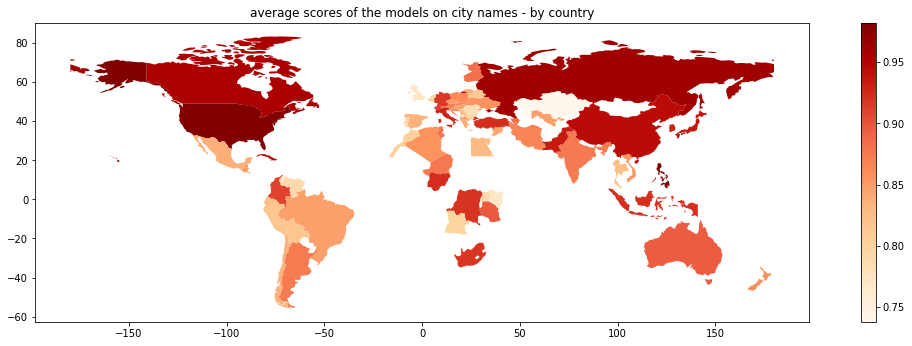

In [49]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(18.5, 5.5)
plt.title('average scores of the models on city names - by country')
gdf_results_city.plot('avg_score', ax=ax, legend=True, cmap='OrRd')
#Saving the figure
plt.savefig('images/results/avg_score_city_names_country.png', bbox_inches='tight')
plt.show()

#### Results by continent 

In [50]:
gdf_results_city.groupby("continent").mean()

,pop_est,gdp_md_est,score_sm,score_md,score_lg,score_trf,avg_score
continent,,,,,,,
Africa,2.390542e+07,1.181430e+05,0.762500,0.830078,0.873958,0.952474,0.854753
Antarctica,4.050000e+03,8.100000e+02,NaN,NaN,NaN,NaN,NaN
Asia,9.338606e+07,1.179460e+06,0.786328,0.881543,0.894434,0.958887,0.880298
Europe,1.913842e+07,6.483302e+05,0.729743,0.818973,0.863560,0.954687,0.841741
North America,3.183567e+07,1.305841e+06,0.834375,0.884635,0.909115,0.961979,0.897526
Oceania,5.254692e+06,2.018407e+05,0.744531,0.922656,0.889062,0.953906,0.877539
Seven seas (open ocean),1.400000e+02,1.600000e+01,NaN,NaN,NaN,NaN,NaN
South America,3.305957e+07,5.183208e+05,0.725174,0.814583,0.865278,0.964062,0.842274


In [51]:
gdf_results_city.groupby("continent").mean().sort_values('avg_score', ascending=False)[['avg_score']].dropna()

,avg_score
continent,
North America,0.897526
Asia,0.880298
Oceania,0.877539
Africa,0.854753
South America,0.842274
Europe,0.841741


In [52]:
gdf_results_continent = gdf_results_city.groupby("continent").mean().reset_index()

In [53]:
gdf_results_continent = world.merge(gdf_results_continent, right_on='continent', left_on='continent')

For each model:

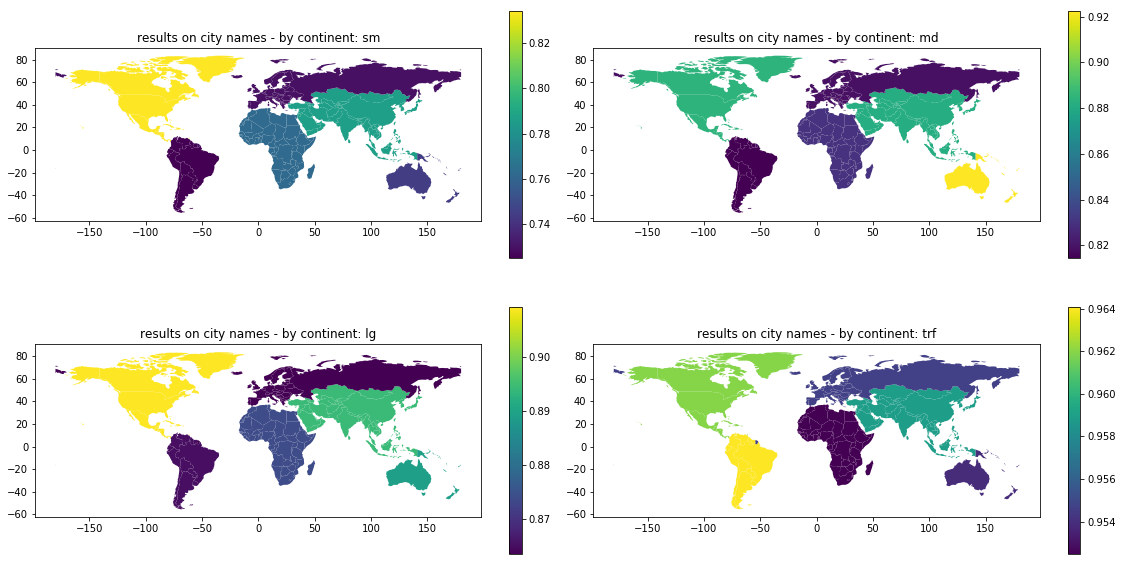

In [54]:
fig, axs = plt.subplots(2,2, figsize=(20, 10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .2, wspace=0.001)

axs = axs.ravel()

for i in range(4):
    model = ['sm','md','lg','trf'][i]
    
    #Defining the figure:
    axs[i].set_title('results on city names - by continent: ' + model)
    gdf_results_continent.plot(column='score_'+model, legend=True, ax = axs[i])
       
plt.savefig('images/results/score_each_models_city_names_continent.png', bbox_inches='tight')
plt.show()

On average:

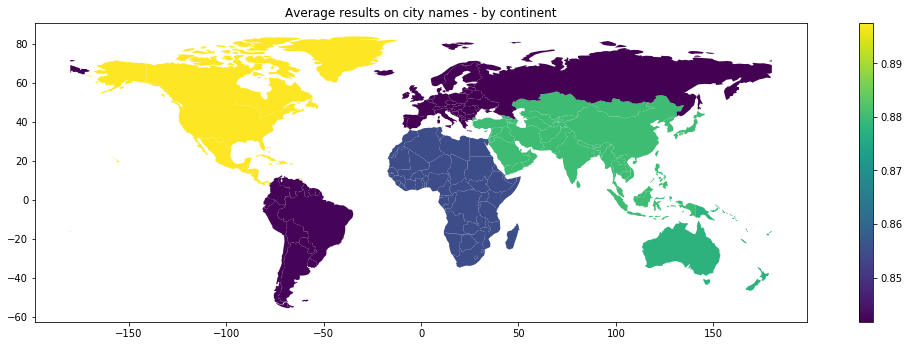

In [55]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(18.5, 5.5)
plt.title('Average results on city names - by continent')
gdf_results_continent.plot('avg_score', ax=ax, legend=True)
#Saving the figure
plt.savefig('images/results/avg_score_city_names_continent.png', bbox_inches='tight')
plt.show()

## Conclusion

For more detailed explanations and conclusions, please visit the [github page](https://adrihans.github.io/Decoding_NER_Biases/) of the project. 